In [4]:
mergeddata = read.csv('/Users/mbrumfield/Documents/depression_ds/mergeddata.csv')
head(mergeddata, 5)

#Creates two way table of counts by Gender and Home Ownership
unweightedtable = ftable(mergeddata$RACE, mergeddata$DEPRESSED)
unweightedtable

,X,SEQN,DEPRESSED,AGEGRP,MARITALSTATUS,PIR,GENDER,RACE,EDUCATION,WTMEC2YR,WTINT2YR,SDMVPSU,SDMVSTRA
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,83732,0,2,1,2,1,2,4,135629.51,134671.37,1,125
2,1,83733,0,1,2,1,1,2,2,25282.43,24328.56,1,125
3,2,83734,0,2,1,2,1,2,2,12575.84,12400.01,1,131
4,3,83735,1,2,4,3,2,2,4,102078.63,102718.00,1,131
5,4,83736,0,1,2,1,2,3,3,18234.74,17627.67,2,126


      0    1
            
1  1452  144
2  1560  157
3  1017   88
4   701   43

In [5]:
require(survey)

#Specify survey design
mergeddatadesign = svydesign(id=~SDMVPSU, strata=~SDMVSTRA, nest=TRUE, data=mergeddata, weights=mergeddata$WTMEC2YR)

#Create your two‐way table
weightedtable = svytable(~RACE + DEPRESSED, mergeddatadesign) 
weightedtable

    DEPRESSED
RACE         0         1
   1  30776502   2679522
   2 131666194  10518621
   3  22653717   2035299
   4  17962868   1398980

Loading required package: ggplot2



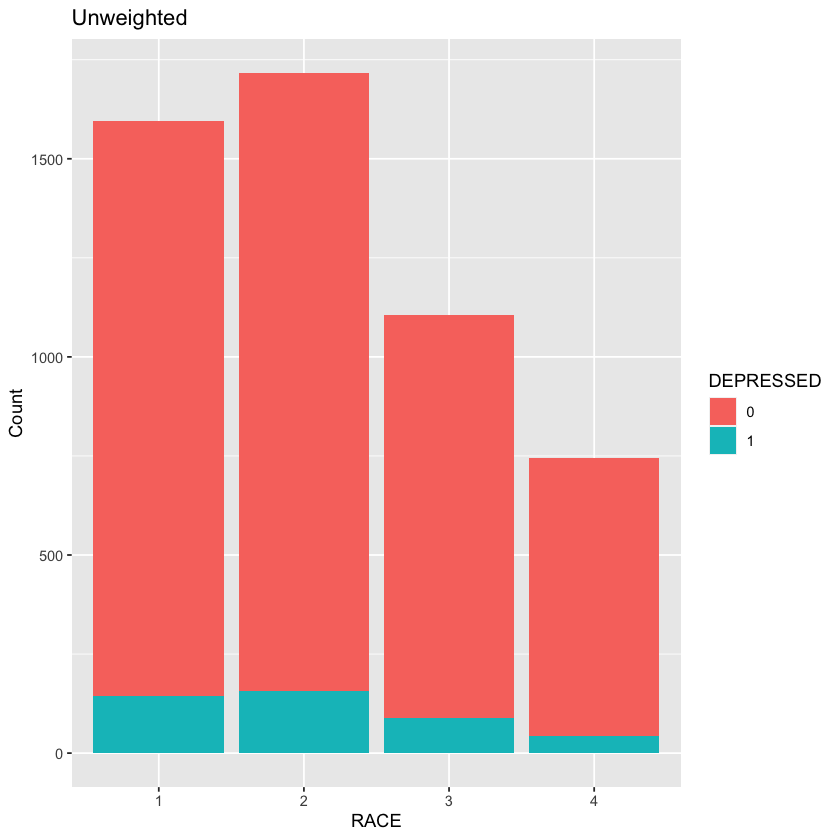

In [6]:
require(ggplot2)

#Converts unweightedtable into data frame to be used with ggplot()
unweighteddata = as.data.frame(unweightedtable)

#Assigns the column names Gender, Home_Ownership, and Counts to the data frame
colnames(unweighteddata) = c("RACE", "DEPRESSED", "Count")

ggplot(unweighteddata, aes(x = RACE, y = Count, fill = DEPRESSED)) + 
    geom_bar(
        #position = "fill",
        stat = "identity") +
    #scale_y_continuous(labels = percent_format()) +
    labs(x = "RACE", y = "Count", fill = "DEPRESSED") + 
    ggtitle("Unweighted")

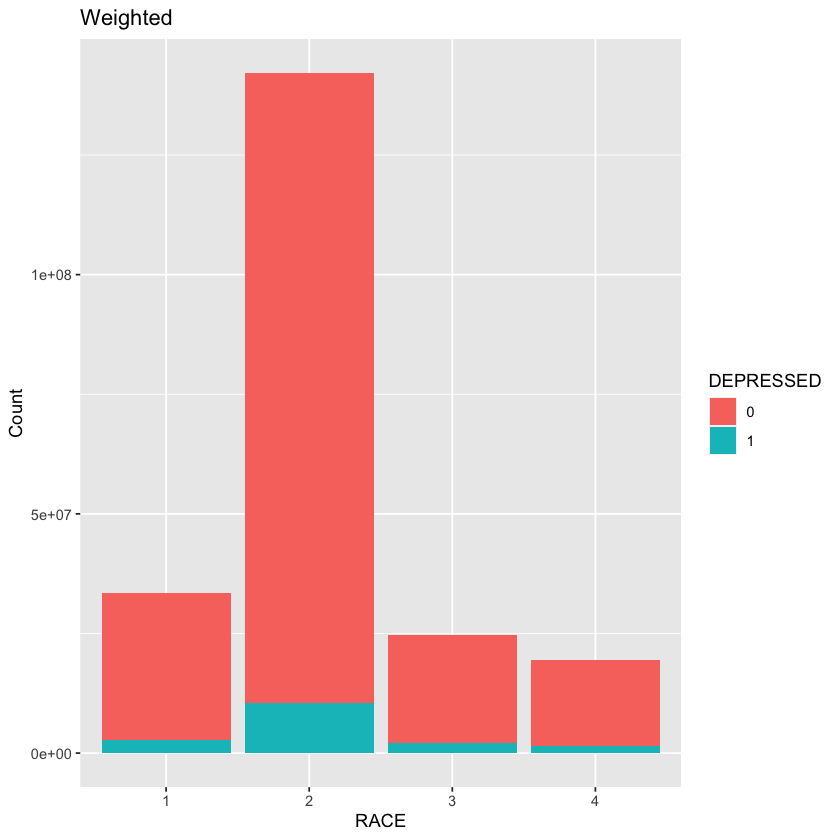

In [7]:
#Converts weightedtable into a data frame to be used with ggplot()
weighteddata = as.data.frame(weightedtable)

#Assigns the column names Gender, Home_Ownership, and Counts to the data frame
colnames(weighteddata) = c("RACE", "DEPRESSED", "Count")

ggplot(weighteddata, aes(x = RACE, y = Count, fill = DEPRESSED)) + 
    geom_bar(
        #position = "fill",
        stat = "identity") +
    #scale_y_continuous(labels = percent_format()) +
    labs(x = "RACE", y = "Count", fill = "DEPRESSED") + 
    ggtitle("Weighted")

In [8]:
# For the Rao‐Scott correction, we use the weighted tables from the RW section and run a chi‐
# square test using equation [2]. However, we also take into accound weight variability by doing a
# few more calculations.
summary(weightedtable, statistic = "Chisq")

    DEPRESSED
RACE         0         1
   1  30776502   2679522
   2 131666194  10518621
   3  22653717   2035299
   4  17962868   1398980

	Pearson's X^2: Rao & Scott adjustment

data:  svychisq(~RACE + DEPRESSED, design = mergeddatadesign, statistic = "Chisq")
X-squared = 0.81156, df = 3, p-value = 0.9174
